# Neural Net Models

Notebook for attempting various neural networks. We will attempt a CNN, RNN and LSTM neural net, all approaches that are fairly popular for time series data. Each neural net will be fit with a single hidden layer of size 64 (approximately the mean of our 103 X variables and 24 y variables) and we will use a dropout layer of 0.5 when to avoid overfitting.

## Problem Statement

Predict electricity prices in Spain for each hour of the upcoming day more accurately than estimates provided by the Spanish transmission agent and operator. 

Use information available during the 2pm-3pm window the previous day during which generators in Spain submit their bids. 

## Contents

- [Imports](#Imports)
- [Functions Used](#Functions-Used)
- [Prepare Data](#Prepare-Data)
- [Recurrent Neural Network](#RNN)
- [Convolutional Neural Network](#CNN)
- [Long Short Term Memory](#LSTM-Model)
- [Results for Analysis](#Results-for-Analysis)

### Imports

In [196]:
# General Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# General modeling imports
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Neural Net imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [173]:
df = pd.read_csv('../Data/Analysis/model_data.csv')
visuals = pd.read_csv('../Data/intermediary/energy.csv')

# visuals contains the prices attached to their original hour
# and will be used to visualize and compare our predictions
visuals.set_index(pd.DatetimeIndex(visuals['time']), inplace=True)
visuals = visuals[['price_actual','price_day_ahead']]

In [174]:
# Prediction df for appending test predictions too
pred_df = visuals[visuals.index.year == 2018]

### Functions Used

In [175]:
# Function for evaluating the regressions
# and outputting a dataframe of different metrics
# for each hour predicted
def reg_metrics(y_train, y_train_p, y_test, y_test_p, mod):
    test_rmse = np.sqrt(((y_test-y_test_p)**(2)).mean())
    train_r2 = metrics.r2_score(y_train, y_train_p, multioutput='raw_values')
    test_r2 =  metrics.r2_score(y_test, y_test_p, multioutput='raw_values')
    metrics_df = pd.DataFrame(data = zip(test_rmse, train_r2, test_r2),
                              columns=[mod+'test_rmse',mod+'train_r2',mod+'test_r2'])
    return metrics_df

# function to convert predictions into dataframe for plotting
def append_preds(preds, previous_preds, name):
    new_preds = pd.DataFrame(np.ravel(preds),columns=[name], index=previous_preds.index)
    return previous_preds.join(new_preds)

### Prepare Data

In [176]:
# Set up data frame for modeling
# Drop time column
df.drop(columns=['time'], inplace=True)
# set index as date
df.set_index(pd.DatetimeIndex(df['date']), inplace=True)
# sort index
df.sort_index(inplace=True)
# drop hour of day and date column
df.drop(columns=['hour_of_day','date'], inplace=True)

# Get columns for y
y_cols = [col for col in df.columns if col.startswith('t_price')]

# Set X and y
X = df.drop(columns=y_cols)
y = df[y_cols]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    shuffle=False)
# Need validation set as well for neural networks
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,
                                                  shuffle=False,
                                                  test_size=0.2)

# Scaled data for Neural Networks
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_val = ss.transform(X_val)
Z_test = ss.transform(X_test)

In [177]:
# y_train that matches y_train in other notebooks so we can have
# consistent metrics and predictions to compare
y_full_train = np.concatenate([y_train, y_val], axis=0)
Z_train_full = np.concatenate([Z_train, Z_val], axis=0)

In [193]:
# Create training sequences
train_sequences = TimeseriesGenerator(Z_train, 
                                      y_train.values, 
                                      length=7, 
                                      batch_size=16)

# Full train sequence
full_sequences = TimeseriesGenerator(Z_train_full, 
                                      y_full_train, 
                                      length=7, 
                                      batch_size=16)

# Create val sequences
val_sequences = TimeseriesGenerator(Z_val, 
                                    y_val.values, 
                                    length=7, 
                                    batch_size=16)

# Create test sequences
test_sequences = TimeseriesGenerator(Z_test, 
                                     y_test.values, 
                                     length=7, 
                                     batch_size=16)

In [179]:
X_train.shape

(875, 103)

### RNN

In [199]:
# Design RNN
rnn_model = Sequential()
# RNN Layers
rnn_model.add(GRU(103, input_shape=(7, 103), 
              return_sequences=True)) 
rnn_model.add(GRU(103, return_sequences=False))
rnn_model.add(Dropout(0.25))
# Hidden dense layer
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dropout(0.25))
# Output layer
rnn_model.add(Dense(24, activation='linear'))
# Compile model
rnn_model.compile(loss='mse', optimizer='adam')

In [200]:
rnn_hist = rnn_model.fit_generator(train_sequences,
                     epochs=100,
                     validation_data=val_sequences,
                     verbose=0)

model.save('./rnn.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']


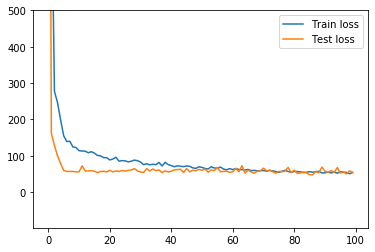

In [202]:
# Plot the loss curve
plt.plot(rnn_hist.history['loss'], label = 'Train loss')
plt.plot(rnn_hist.history['val_loss'], label = 'Test loss')
plt.ylim(top=500)
plt.legend();

It looks as though our model has essentially finished fitting and is not overfit. Let's look at our regression metrics to compare to previous models.

In [206]:
# Get predictions
rnn_train_preds = rnn_model.predict(full_sequences)
rnn_test_preds = rnn_model.predict(test_sequences)

In [208]:
# Get stats
# can only include starting from 8th day of y actual since the 
# generator used length=7
rnn_metrics = reg_metrics(y_full_train[7:], rnn_train_preds, y_test[7:], rnn_test_preds,'rnn_')
# Display summary
rnn_metrics.describe().T

,count,mean,std,min,25%,50%,75%,max
rnn_test_rmse,24.0,7.813295,0.724297,6.299555,7.179868,7.936063,8.239226,8.983103
rnn_train_r2,24.0,0.856659,0.044019,0.783221,0.815191,0.863188,0.893998,0.910654
rnn_test_r2,24.0,0.456544,0.091274,0.315334,0.353073,0.490102,0.533040,0.566119


Unfortunately we have yet to be able to properly implement a GridSearch for the rnn model, but these results are not very good so we will move on to the other nn's for now instead of manually gridsearching the rnn. 

### CNN

In [136]:
# Expand dimensions for CNN
# Thanks parsethis
# https://stackoverflow.com/questions/43396572/dimension-of-shape-in-conv1d/43399308#43399308
Z_train_cnn = np.expand_dims(Z_train, axis=2)
Z_test_cnn = np.expand_dims(Z_test, axis=2)
Z_val_cnn = np.expand_dims(Z_val, axis=2)
Z_train_full_cnn = np.expand_dims(Z_train_full, axis=2)

In [147]:
# Function to gridsearch cnn
def cnn_function(kernel = 7, pool = 1, drop = 0.25, hidden = 64):
    # Design CNN
    cnn_model = Sequential()
    # CNN Layers 
    cnn_model.add(Conv1D(filters = 103,       
                     kernel_size = kernel,  
                     activation = 'relu',   
                     input_shape = (103,1))) 
    cnn_model.add(MaxPooling1D(pool_size=pool))
    cnn_model.add(Flatten())
    cnn_model.add(Dropout(drop))
    # Hidden dense layer
    cnn_model.add(Dense(hidden, activation='relu'))
    cnn_model.add(Dropout(drop))
    # Output layer
    cnn_model.add(Dense(24, activation='linear'))
    # Compile Model
    cnn_model.compile(loss='mse', optimizer='adam')
    # return model
    return cnn_model

# wrapper for sklearn gridsearch compatibility
cnn = KerasRegressor(build_fn=cnn_function, 
                     batch_size = 128,
                     epochs = 100,
                     verbose = 0)

# parameters
cnn_params = {
    'kernel': [3, 7, 15],
    'drop': [0.25, 0.5],
    'pool': [2, 4, 7],
    'hidden': [80, 64] 
}

# set up gridsearch
cnn_gs = GridSearchCV(cnn,
                      param_grid=cnn_params,
                      cv=TimeSeriesSplit(n_splits=4))

# fit model
cnn_gs.fit(Z_train_full_cnn, y_full_train)

# Get predictions
cnn_train_preds = cnn_gs.predict(Z_train_full_cnn)
cnn_test_preds = cnn_gs.predict(Z_test_cnn)

# Show metrics and best parameters
print(f'Best hyperparameters: {cnn_gs.best_params_}\n')

Best hyperparameters: {'drop': 0.25, 'hidden': 80, 'kernel': 15, 'pool': 2}



In [148]:
# Save model
cnn_gs.best_estimator_.model.save('./Models/cnn.h5')

In [149]:
# Get stats
cnn_metrics = reg_metrics(y_full_train, cnn_train_preds, y_test, cnn_test_preds,'cnn_')
# Display summary
cnn_metrics.describe().T

,count,mean,std,min,25%,50%,75%,max
cnn_test_rmse,24.0,6.414636,0.497576,5.551649,6.054459,6.451337,6.791788,7.212440
cnn_train_r2,24.0,0.779099,0.031438,0.727605,0.748694,0.783502,0.797284,0.831626
cnn_test_r2,24.0,0.658081,0.067174,0.473562,0.626033,0.680035,0.711517,0.729775


In [216]:
# Append predictions to pred df
pred_df = append_preds(cnn_test_preds, pred_df, 'cnn')
pred_df.head(2)

,price_actual,price_day_ahead,cnn
time,,,
2018-01-01 00:00:00+00:00,20.76,6.74,40.298073
2018-01-01 01:00:00+00:00,19.02,4.74,37.405537


The CNN performed quite well and is one of our better models so far, though it does not match the performance of the SVR model.

### LSTM Model

LSTM models function by progressively 'forgetting' past data points more and more so that they still have an effect on the model but as they are progressively farther in the 'past' than our current position we rely on them less. 

They are a popular model for speach recognition and time series analysis among other things.

For our LSTM Model we will tune the following hyperparameters:
- Dropout % for regularization
- Number of nodes in the hidden and lstm layers

In [152]:
# Function to gridsearch cnn
def lstm_function(drop = 0.25, hidden = 64, lstm_ = 64):
    # Design lstm
    model = Sequential()
    # LSTM Layer 
    model.add(LSTM(lstm_,            
                   input_shape = (103,1))) 
    model.add(Dropout(drop))
    # Hidden dense layer
    model.add(Dense(hidden, activation='relu'))
    model.add(Dropout(drop))
    # Output layer
    model.add(Dense(24, activation='linear'))
    # Compile Model
    model.compile(loss='mse', optimizer='adam')
    # return model
    return model

# wrapper for sklearn gridsearch compatibility
lstm = KerasRegressor(build_fn=lstm_function, 
                     batch_size = 128,
                     epochs = 100,
                     verbose = 0)

# parameters
lstm_params = {
    'lstm_': [64, 103],
    'drop': [0.25, 0.5],
    'hidden': [80, 64] 
}

# set up gridsearch
lstm_gs = GridSearchCV(lstm,
                      param_grid=lstm_params,
                      cv=TimeSeriesSplit(n_splits=4))

# fit model
lstm_gs.fit(Z_train_full_cnn, y_full_train)

# Get predictions
lstm_train_preds = lstm_gs.predict(Z_train_full_cnn)
lstm_test_preds = lstm_gs.predict(Z_test_cnn)

# Show metrics and best parameters
print(f'Best hyperparameters: {lstm_gs.best_params_}\n')

Best hyperparameters: {'drop': 0.5, 'hidden': 80, 'lstm_': 103}



In [153]:
# Save model
lstm_gs.best_estimator_.model.save('./Models/lstm.h5')

In [154]:
# Get stats
lstm_metrics = reg_metrics(y_full_train, lstm_train_preds, y_test, lstm_test_preds,'lstm_')
# Display summary
lstm_metrics.describe().T

,count,mean,std,min,25%,50%,75%,max
lstm_test_rmse,24.0,9.201877,0.971797,7.198084,8.578903,9.311308,9.999684,10.757533
lstm_train_r2,24.0,0.500670,0.048555,0.405865,0.479569,0.512275,0.528729,0.591527
lstm_test_r2,24.0,0.308769,0.064115,0.202498,0.259935,0.302787,0.362163,0.403073


Our LSTM model performed very poorly, perhaps editing the architecture could improve performance. However, this is our worst performing model so far and so pursuing further improvement does not seem like a good use of time.

In [217]:
# Append predictions to pred df
pred_df = append_preds(lstm_test_preds, pred_df, 'lstm')
pred_df.head(2)

,price_actual,price_day_ahead,cnn,lstm
time,,,,
2018-01-01 00:00:00+00:00,20.76,6.74,40.298073,44.006966
2018-01-01 01:00:00+00:00,19.02,4.74,37.405537,41.352783


### Results for Analysis

In [218]:
# Save prediction
pred_df.to_csv('../Data/Analysis/nn_predictions.csv')

In [213]:
# metrics df
metrics_df = pd.concat([rnn_metrics, cnn_metrics,
                        lstm_metrics],
                        axis=1, sort=False)

metrics_df.to_csv('../Data/Analysis/nn_metrics.csv')

In [219]:
pred_df.head()

,price_actual,price_day_ahead,cnn,lstm
time,,,,
2018-01-01 00:00:00+00:00,20.76,6.74,40.298073,44.006966
2018-01-01 01:00:00+00:00,19.02,4.74,37.405537,41.352783
2018-01-01 02:00:00+00:00,17.90,3.66,34.922657,39.739094
2018-01-01 03:00:00+00:00,20.88,2.30,33.367092,38.886688
2018-01-01 04:00:00+00:00,18.83,2.30,31.794762,38.886810
